<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 4</strong>
</div>
<div style="text-align: center;">
<strong>Finite element method for elliptic problems</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

In this notebook we will review the Finite Element Method (FEM) for approximating solutions of standard elliptic problems.

In [1]:
from math import pi
import matplotlib.pyplot as plt
import numpy as np    
from numpy.linalg import inv, norm
from scipy.linalg import eigvals, expm
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve
import time
from helpers import elliptic_reference_solution

np.random.seed(42)

# 1 Introduction

Before going any further, we need to implement the shape function and basis functions of the pc4-01-P1-approximation notebook.

### Exercise

{exercise}
Copy/paste the functions you defined in pc4_01.

In [2]:
# Shape function and basis functions:
phi = lambda x: np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)
Phi = lambda j, x: phi((x - xx[j])/h)

# 2 Poisson equation with homogeneous Dirichlet boundary conditions

We consider the one-dimensional Poisson equation with homogeneous Dirichlet boundary conditions:

\begin{align}
-u''(x) &= f(x) && \text{in } \Omega = (-1,1),\\
u(-1) &= u(1) = 0.
\end{align}

The variational formulation of the problem is to find $u\in V=\{v\in H^1(-1,1),\,v(\pm1)=0\}$ such that

$$
\int_{\Omega} u'(x)v'(x)dx = \int_{\Omega} f(x)v(x)dx,
$$

for all $v\in V$.

We discretize the interval $[-1,1]$ using a set of $m+2$ points 
$$
x_j = -1 + jh, \qquad h = 2/(m+1),\qquad j=0,\ldots,m+1,
$$ 
which provides associate basis functions $x\mapsto\phi_j(x)$, $j=1,\ldots,m$.

We seek a finite element approximation of $u$

$$
u_h(x)
= \sum_{j=1}^m u_j\phi_j(x)
$$
that verifies the Galerkin variational problem

$$
\int_{\Omega} u_h'(x)\phi_i'(x)  dx  
=
\int_{\Omega} f(x)\phi_i(x) dx
\quad \text{for all $i=1,\ldots,m$}.
$$

By substituting the expression of $u_h$ into the weak formulation, we obtain the following linear system

$$
\sum_{j=1}^{m} u_j
\int_{\Omega} \phi_i'(x)\phi_j'(x)dx
=
\int_{\Omega} f(x)\phi_i(x) dx
\quad \text{for all $i=1,\ldots,m$.}
$$ 

We set
$$
A_{ij} = \int_{\Omega} \phi_i'(x)\phi_j'(x)dx,
\quad \text{and} \quad
F_i = \int_{\Omega} f(x)\phi_i(x)dx.
$$
Then the linear system can be written as
$$
A U = F,
$$
where 
$$
U = (u_1,\ldots,u_m)^T,
\quad F = (F_1,\ldots,F_m)^T,
\quad A= (A_{ij})_{1\leq i,j \leq m}
.
$$

Let $T$ be the $m\times m$ tridiagonal matrix defined by $T_{i,i+1} = T_{i+1,i} = 1$ for $i=1,\ldots,m-1$ and $T_{i,j} = 0$ otherwise:

$$
T =
\begin{pmatrix}
0 & 1 & 0 & \cdots & 0\\
1 & 0 & 1 & \ddots & \vdots\\
0 & \ddots & \ddots & \ddots & 0\\
\vdots & \ddots & 1 & 0 & 1\\
0 & \cdots & 0 & 1 & 0\\
\end{pmatrix}.
$$

Then the matrices A can be expressed as
$$
A =\frac{1}{h}
\left(
2 I - T
\right)
.
$$

In order to solve the linear system $AU = F$, we need to evaluate the right-hand side $F$. We propose to
use the following approximation
$$
F_i = 
\int_{\Omega} f(x) \phi_i(x) dx \approx
\int_{\Omega} \sum_{j=1}^{m} f(x_j) \phi_j(x)\phi_i(x) dx,
$$
which also reads
$$
F = M \begin{pmatrix} f(x_1) \\ \vdots \\ f(x_m) \end{pmatrix}
,\quad
M_{ij} = \int_{\Omega} \phi_j(x)\phi_i(x) dx,
\quad
M = (M_{ij})_{1\leq i,j \leq m}.
$$

The matrix $M$ can also be expressed thanks to $T$

$$
M =
\frac{h}{3}
\left(
2I + \frac{1}{2}T
\right)
.
$$

## 2.1 Assembling matrices

### Exercise

{exercise}
Assemble the matrix A and M.

In [3]:
def assemble_matrices(m, h):
    T = diags([1] * (m - 1), offsets=1) + diags([1] * (m - 1), offsets=-1)
    A=1/h*(2*eye(m)-T)
    M=h/3*(2*eye(m)+1/2*T)
    # assemble the matrices A and M
    # hints: use the diag() and eye() functions from scipy.sparse 
    return A, M

### Validation

In [4]:
m = 10
h = 2/(m + 1)
A, M = assemble_matrices(m, h)
print(A.todense()) # the first line reads : [11.  -5.5  0.   0.   0.   0.   0.   0.   0.   0. ]
print(M.todense()) # the first line reads: [0.12121212 0.03030303 0.0 ... 0.0]

[[11.  -5.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [-5.5 11.  -5.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -5.5 11.  -5.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -5.5 11.  -5.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -5.5 11.  -5.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -5.5 11.  -5.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -5.5 11.  -5.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -5.5 11.  -5.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -5.5 11.  -5.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -5.5 11. ]]
[[0.12121212 0.03030303 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.03030303 0.12121212 0.03030303 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.03030303 0.12121212 0.03030303 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.03030303 0.12121212 0.03030303 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.0303

## 2.2 Assembling the rhs

### Exercise

{exercise}
Assemble the right-hand side of the linear system.

In [5]:
def poisson_RHS(M, f, xx):
    xx_2 = xx[1:-1]
    return M @ f(xx_2)

### Validation

In [6]:
nu = 1
f = lambda x: (2*pi*nu)**2*np.sin(2*pi*nu*x)

m = 10
h = 2/(m + 1)
xx = np.linspace(-1, 1, m + 2)
A, M = assemble_matrices(m, h)

RHS = poisson_RHS(M, f, xx)

print(RHS) # the first resulting parameters should be  5.25694316  4.36762623 -1.62818815

[ 5.25694316  4.36762623 -1.62818815 -5.72037383 -3.12447019  3.12447019
  5.72037383  1.62818815 -4.36762623 -5.25694316]


## 2.3 Solving the linear system

The final setp is to solve $AU = F$.

### Exercise

{exercise}
Assemble the matrices, the rhs, and solve the linear system in the following routine.

In [8]:
def solve_poisson(m, f):
    h = 2/(m + 1)
    xx = np.linspace(-1, 1, m + 2) 

    start = time.time() 
    A, M = assemble_matrices(m, h)
    F = poisson_RHS(M, f, xx)
    end = time.time()
    print(f'Time  (setup): {end-start:.5f}s')
 
    start = time.time() 
    U = spsolve(A,F)
    end = time.time()
    print(f'Time  (solve): {end-start:.5f}s')
    return U

### Validation

Time  (setup): 0.00505s
Time  (solve): 0.01001s
Error (L-inf): 3.22e-03


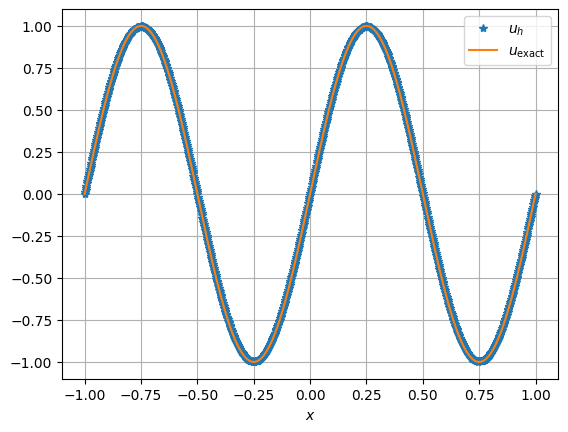

In [9]:
# Setup (problem):
nu = 1
f = lambda x: (2*pi*nu)**2*np.sin(2*pi*nu*x)

# Setup (grid):
xeval = np.linspace(-1, 1, 1000) # evaluation grid
m = 100
h = 2/(m + 1)
xx = np.linspace(-1, 1, m + 2) # computation grid

# Solve Poisson equation:
U = solve_poisson(m, f)

# Evalute the approximate solution on the evaluation grid:
I, XEVAL = np.meshgrid(np.arange(1, m + 1), xeval)
u = Phi(I, XEVAL) @ U

# Compute exact solution:
uex = lambda x: np.sin(2*pi*nu*x)

# Compute the L-inf error:
error = np.max(np.abs(uex(xeval) - u))/np.max(np.abs(uex(xeval)))
print(f'Error (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.grid()
plt.xlabel(r"$x$")
plt.plot(xeval, u, '*',label=r'$u_h$')
plt.plot(xeval, uex(xeval), '-',label=r'$u_\mathrm{exact}$');
plt.legend();

# 3 Constant-coefficient elliptic problem with homogeneous Dirichlet boundary conditions

Let $\mu>0$. We consider the following one-dimensional ellipic problem with homogeneous Dirichlet boundary conditions.
\begin{align}
-u''(x) + \mu u(x) &= f(x) && \text{in } \Omega = (-1,1),\\
u(-1) &= u(1) = 0.
\end{align}

The variational formulation of the problem is to find $u\in V$ such that
$$
\int_{\Omega} u'(x)v'(x)dx + \int_{\Omega} \mu u(x)v(x)dx = \int_{\Omega} f(x)v(x)dx
$$
for all $v\in V$.

We seek a finite element approximation of $u$ of the form

$$
u_h(x)
= \sum_{j=1}^m u_j\phi_j(x),
$$
which verifies the Galerkin variational problem

$$
\int_{\Omega} u_h'(x)\phi_i'(x)  dx + \int_{\Omega} \mu u_h(x) \phi_i(x)dx  
=
\int_{\Omega} f(x)\phi_i(x) dx
\quad \text{for all $i=1,\ldots,m$.}
$$

By substituting the expression of $u_h$ into the weak formulation, we obtain the following linear system

$$
\sum_{j=1}^m u_j
\left(
\int_{\Omega} \phi_i'(x)\phi_j'(x)dx
+
\int_{\Omega} \mu \phi_i(x)\phi_j(x)dx
\right) 
=
\int_{\Omega} f(x) \phi_j(x)dx
\quad \text{for all $i=1,\ldots,m$.}
$$ 

Using the matrices $A$ and $M$ above, we obtain
$$
(A + \mu M) U = F,
$$
where have set once again
$$
U = (u_1,\ldots,u_m)^T,
\quad F = (F_1,\ldots,F_m)^T,
$$
with the same approximation for $F$, i.e.,
$
F = M \begin{pmatrix} f(x_1) \\ \vdots \\ f(x_m) \end{pmatrix}.
$

### Exercise

{exercise}
Implement the solver for this problem.

In [10]:
def solve_elliptic(m, f, mu):
    h = 2/(m + 1)
    xx = np.linspace(-1, 1, m + 2) 

    start = time.time() 
    A, M = assemble_matrices(m, h)
    F = poisson_RHS(M, f, xx)
    end = time.time()
    print(f'Time  (setup): {end-start:.5f}s')
 
    start = time.time() 
    U = spsolve(A+mu*M, F)
    end = time.time()
    print(f'Time  (solve): {end-start:.5f}s')
    
    return U

### Validation

Time  (setup): 0.00501s
Time  (solve): 0.00399s
Error (L-inf): 3.18e-03


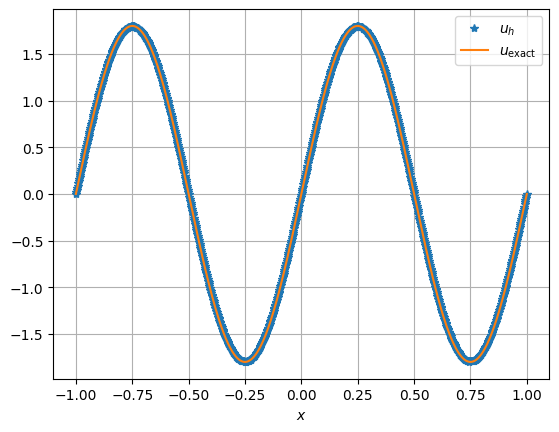

In [11]:
# Setup (problem):
mu = 1.3
nu = 1
B = 1.8
f = lambda x: B*((2*pi*nu)**2 + mu)*np.sin(2*pi*nu*x)

# Setup (grid):
xeval = np.linspace(-1, 1, 1000) # evaluation grid
m = 100
h = 2/(m + 1)
xx = np.linspace(-1, 1, m + 2) # computation grid

# Solve the elliptic problem:
U = solve_elliptic(m, f, mu)

# Evalute the approximate solution on the evaluation grid:
I, XEVAL = np.meshgrid(np.arange(1, m + 1), xeval)
u = Phi(I, XEVAL) @ U

# Compute exact solution:
uex = lambda x: B*np.sin(2*pi*nu*x) # exact solution

# Compute error:
error = np.max(np.abs(uex(xeval) - u))/np.max(np.abs(uex(xeval)))
print(f'Error (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.grid()
plt.xlabel(r"$x$")
plt.plot(xeval, u, '*',label=r'$u_h$')
plt.plot(xeval, uex(xeval), '-',label=r'$u_\mathrm{exact}$');
plt.legend();